# Tuning LoRA Hyperparameters - Reproducing Tuning Results, Summary

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-230810-1443'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-230810-1443 => Completed
Best parameters found: {'sst2-learning-rate': '0.0003979340903356249'}


{'sst2-learning-rate': 0.0003979340903356249}

### Verify Reproducability

Let's pick a winning combination of hyperparameters and then validate that we weren't just lucky, but can repreatably produce sufficient results with those hyperparameter values.

It's up to us how small the adapters should become versus the performance we want to achieve. We have seen that we can roughly match the performance of the full-finetuning. In our case we needed a little bit more than one percent of the original parameters. With a larger model and exploiting the Intrinsic Dimension (see the first article) we would expect the percentage to go down a bit.

We will pick simple scenarios:
- All: We train adapters for all components on all laters with `r=8`.
- FF Up: We tune one adapter for each positionwise feed forward up projection with `r=16`, 12 in total, as we have 12 layers.

## Show comparisons with baseline here?

In [5]:
import concurrent.futures
import time

import traceback
import sys

# (r, conf)
combinations = [
    ( 2, 'all'),
    ( 8, 'all'),
    (16, 'all'),
    ( 4, 'ff_u'),
    ( 8, 'ff_u'),
    ( 8, 'ff_d'),
    (16, 'ff_u'),
    ( 8, 'att_v+ff_u'),
    ( 8, '12_lowest2_att_v_ff_u_ff_d'),
    ( 8, '12_top2_att_v_ff_u_ff_d'),
]

def do_capture(r, conf):
    title = f'LoRA {conf}, r={r}'
    print(f'Submitting {title}')
    est = PyTorch(**get_default_estimator_parameters())
    est.set_hyperparameters(**{'sst2-lora-r': r, 'sst2-lora-config': conf, **best_hyperparameters})
    try:
        capture_results(title, est, job_name=f'{r}-{conf.replace("_", "-").replace("+", "-")}')
    except Exception: 
        print(traceback.format_exc())

executor = concurrent.futures.ThreadPoolExecutor(max_workers=5)
futures = [executor.submit(do_capture, *args) for args in combinations]

print('Waiting ...')
concurrent.futures.wait(futures)

Submitting LoRA all, r=2
Submitting LoRA all, r=8
Submitting LoRA all, r=16
Submitting LoRA ff_u, r=4
Submitting LoRA ff_u, r=8
Waiting ...
Using provided s3_resourceUsing provided s3_resource

Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,3.0,4-ff-u-230811-2210-003-5eb5d2fb,Completed,2023-08-11 22:12:23+02:00,2023-08-11 22:27:22+02:00,899.0,4-ff-u-230811-2210,0.941514
2,0.0,4-ff-u-230811-2210-001-acf910e6,Completed,2023-08-11 22:12:14+02:00,2023-08-11 22:27:03+02:00,889.0,4-ff-u-230811-2210,0.939220
1,1.0,4-ff-u-230811-2210-002-e9a0e98f,Completed,2023-08-11 22:12:14+02:00,2023-08-11 22:27:53+02:00,939.0,4-ff-u-230811-2210,0.938073


Cache Hit/Miss: M.M.M.
Submitting LoRA ff_d, r=8
.!
Using provided s3_resource
Tuning job 8-ff-u-230811-2211        status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9415137767791748 Highest 0.9449541568756104


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,3.0,8-ff-u-230811-2211-003-cea8090a,Completed,2023-08-11 22:12:32+02:00,2023-08-11 22:27:12+02:00,880.0,8-ff-u-230811-2211,0.944954
1,1.0,8-ff-u-230811-2211-002-0fccd319,Completed,2023-08-11 22:12:22+02:00,2023-08-11 22:27:17+02:00,895.0,8-ff-u-230811-2211,0.944954
2,0.0,8-ff-u-230811-2211-001-0566d368,Completed,2023-08-11 22:12:15+02:00,2023-08-11 22:27:05+02:00,890.0,8-ff-u-230811-2211,0.941514


Cache Hit/Miss: M.M.M
Submitting LoRA ff_u, r=16
.Using provided s3_resource
...........................................................................................................................................................................................!
Tuning job 8-all-230811-2210         status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9449541568756104 Highest 0.9472476840019226


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,2.0,8-all-230811-2210-002-a7bde3de,Completed,2023-08-11 22:12:23+02:00,2023-08-11 22:30:58+02:00,1115.0,8-all-230811-2210,0.947248
2,0.0,8-all-230811-2210-001-77ee6bfb,Completed,2023-08-11 22:12:17+02:00,2023-08-11 22:29:28+02:00,1031.0,8-all-230811-2210,0.947248
0,3.0,8-all-230811-2210-003-b0575de3,Completed,2023-08-11 22:12:27+02:00,2023-08-11 22:28:07+02:00,940.0,8-all-230811-2210,0.944954


Cache Hit/Miss: M.M..M.
Submitting LoRA att_v+ff_u, r=8
Using provided s3_resource
.......................................!
Tuning job 16-all-230811-2210        status: Completed
..
Number of training jobs with valid objective: 3
Lowest: 0.9334862232208252 Highest 0.9564220309257507


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,1.0,16-all-230811-2210-001-216e5179,Completed,2023-08-11 22:12:16+02:00,2023-08-11 22:30:46+02:00,1110.0,16-all-230811-2210,0.956422
1,2.0,16-all-230811-2210-002-5e5cbaca,Completed,2023-08-11 22:12:18+02:00,2023-08-11 22:29:28+02:00,1030.0,16-all-230811-2210,0.949541
0,3.0,16-all-230811-2210-003-70bbcb68,Completed,2023-08-11 22:12:18+02:00,2023-08-11 22:24:59+02:00,761.0,16-all-230811-2210,0.933486


Cache Hit/Miss: M..MM
Submitting LoRA 12_lowest2_att_v_ff_u_ff_d, r=8
.Using provided s3_resource
.................................................................................................................................................................................!
Tuning job 2-all-230811-2211         status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9426605701446533 Highest 0.9483944773674011


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,0.0,2-all-230811-2211-001-0ed08720,Completed,2023-08-11 22:12:23+02:00,2023-08-11 22:30:54+02:00,1111.0,2-all-230811-2211,0.948394
0,2.0,2-all-230811-2211-003-323f112d,Completed,2023-08-11 22:12:20+02:00,2023-08-11 22:33:06+02:00,1246.0,2-all-230811-2211,0.947248
1,1.0,2-all-230811-2211-002-802ca8f4,Completed,2023-08-11 22:12:19+02:00,2023-08-11 22:28:04+02:00,945.0,2-all-230811-2211,0.942661


Cache Hit/Miss: MMM..
..Submitting LoRA 12_top2_att_v_ff_u_ff_d, r=8
Using provided s3_resource
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
Tuning job 8-ff-d-230811-2228        status: Completed
.
Number of training jobs with valid objective: 3
Lowest: 0.9311926364898682 Highest 0.9380733966827393


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,2.0,8-ff-d-230811-2228-002-d6b10af3,Completed,2023-08-11 22:29:53+02:00,2023-08-11 22:44:33+02:00,880.0,8-ff-d-230811-2228,0.938073
0,3.0,8-ff-d-230811-2228-003-d82e9478,Completed,2023-08-11 22:30:06+02:00,2023-08-11 22:44:51+02:00,885.0,8-ff-d-230811-2228,0.935780
2,1.0,8-ff-d-230811-2228-001-7a96d28a,Completed,2023-08-11 22:30:00+02:00,2023-08-11 22:42:54+02:00,774.0,8-ff-d-230811-2228,0.931193


Cache Hit/Miss: MM!
.MTuning job 16-ff-u-230811-2228       status: Completed
.

Number of training jobs with valid objective: 3
Lowest: 0.9323394298553467 Highest 0.9506880640983582


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,3.0,16-ff-u-230811-2228-003-6a0d6b3f,Completed,2023-08-11 22:30:02+02:00,2023-08-11 22:44:46+02:00,884.0,16-ff-u-230811-2228,0.950688
2,0.0,16-ff-u-230811-2228-001-b98f78b1,Completed,2023-08-11 22:30:05+02:00,2023-08-11 22:44:54+02:00,889.0,16-ff-u-230811-2228,0.940367
1,2.0,16-ff-u-230811-2228-002-a39e88c2,Completed,2023-08-11 22:30:07+02:00,2023-08-11 22:41:56+02:00,709.0,16-ff-u-230811-2228,0.932339


Cache Hit/Miss: MMM.
..............................................!
Tuning job 8-12-lowest2-att-v-f-230811-2232 status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.7683486342430115 Highest 0.8291284441947937


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,3.0,8-12-lowest2-att-v-f-230811-2232-003-013c5438,Completed,2023-08-11 22:34:14+02:00,2023-08-11 22:46:02+02:00,708.0,8-12-lowest2-att-v-f-230811-2232,0.829128
2,0.0,8-12-lowest2-att-v-f-230811-2232-001-da64d0e9,Completed,2023-08-11 22:34:10+02:00,2023-08-11 22:45:53+02:00,703.0,8-12-lowest2-att-v-f-230811-2232,0.810780
1,2.0,8-12-lowest2-att-v-f-230811-2232-002-a53682d2,Completed,2023-08-11 22:34:56+02:00,2023-08-11 22:45:45+02:00,649.0,8-12-lowest2-att-v-f-230811-2232,0.768349


Cache Hit/Miss: M.MM.
.........................................!
Tuning job 8-att-v-ff-u-230811-2232  status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.9323394298553467 Highest 0.9506880640983582


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,1.0,8-att-v-ff-u-230811-2232-002-8b9e846d,Completed,2023-08-11 22:33:24+02:00,2023-08-11 22:48:48+02:00,924.0,8-att-v-ff-u-230811-2232,0.950688
0,3.0,8-att-v-ff-u-230811-2232-003-7104c15a,Completed,2023-08-11 22:33:25+02:00,2023-08-11 22:48:49+02:00,924.0,8-att-v-ff-u-230811-2232,0.948394
2,0.0,8-att-v-ff-u-230811-2232-001-e80f4d65,Completed,2023-08-11 22:33:24+02:00,2023-08-11 22:46:33+02:00,789.0,8-att-v-ff-u-230811-2232,0.932339


Cache Hit/Miss: MM.M
.............!
Tuning job 8-12-top2-att-v-ff-u-230811-2236 status: Completed

Number of training jobs with valid objective: 3
Lowest: 0.7752293348312378 Highest 0.8268348574638367


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,1.0,8-12-top2-att-v-ff-u-230811-2236-002-4a659cc7,Completed,2023-08-11 22:37:20+02:00,2023-08-11 22:49:03+02:00,703.0,8-12-top2-att-v-ff-u-230811-2236,0.826835
0,2.0,8-12-top2-att-v-ff-u-230811-2236-003-5d98b178,Completed,2023-08-11 22:37:27+02:00,2023-08-11 22:48:16+02:00,649.0,8-12-top2-att-v-ff-u-230811-2236,0.775229
2,0.0,8-12-top2-att-v-ff-u-230811-2236-001-da942ad2,Completed,2023-08-11 22:37:18+02:00,2023-08-11 22:48:02+02:00,644.0,8-12-top2-att-v-ff-u-230811-2236,0.775229


Cache Hit/Miss: MMM


DoneAndNotDoneFutures(done={<Future at 0x2bbf65810 state=finished returned NoneType>, <Future at 0x2bbf64640 state=finished returned NoneType>, <Future at 0x2bbf64670 state=finished returned NoneType>, <Future at 0x2bbf65690 state=finished returned NoneType>, <Future at 0x2bbf658d0 state=finished returned NoneType>, <Future at 0x2bbf64700 state=finished returned NoneType>, <Future at 0x2bbf65750 state=finished returned NoneType>, <Future at 0x2bbf65990 state=finished returned NoneType>, <Future at 0x2bbf653c0 state=finished returned NoneType>, <Future at 0x1100ab9d0 state=finished returned NoneType>}, not_done=set())

,target_tuner_name,title,objective_metric_mean,objective_metric_std,parameters_relative,train_speed_median,gpu_memory_max
0,capture-230810-2012,Full Finetuning,0.946865,0.008683,100.000000,1841.949,79.4
1,capture-230810-2030,Classifier Only,0.827217,0.003504,0.475045,11877.474,13.3
2,capture-230810-2042,LoRA Base,0.942661,0.002294,1.539733,1937.174,82.9
3,capture-230810-2100,LoRA Paper,0.939602,0.002387,0.711642,3610.229,24.0
4,4-ff-u-230811-2210,"LoRA ff_u, r=4",0.939602,0.001752,0.622918,2208.921,66.9
5,8-ff-u-230811-2211,"LoRA ff_u, r=8",0.943807,0.001986,0.770792,2214.181,66.9
6,8-all-230811-2210,"LoRA all, r=8",0.946483,0.001324,1.539733,1548.973,82.9
7,16-all-230811-2210,"LoRA all, r=16",0.946483,0.011770,2.604422,1547.748,83.2
8,2-all-230811-2211,"LoRA all, r=2",0.946101,0.003034,0.741217,1294.105,82.8
9,8-ff-d-230811-2228,"LoRA ff_d, r=8",0.935015,0.003504,0.770792,2779.811,95.0


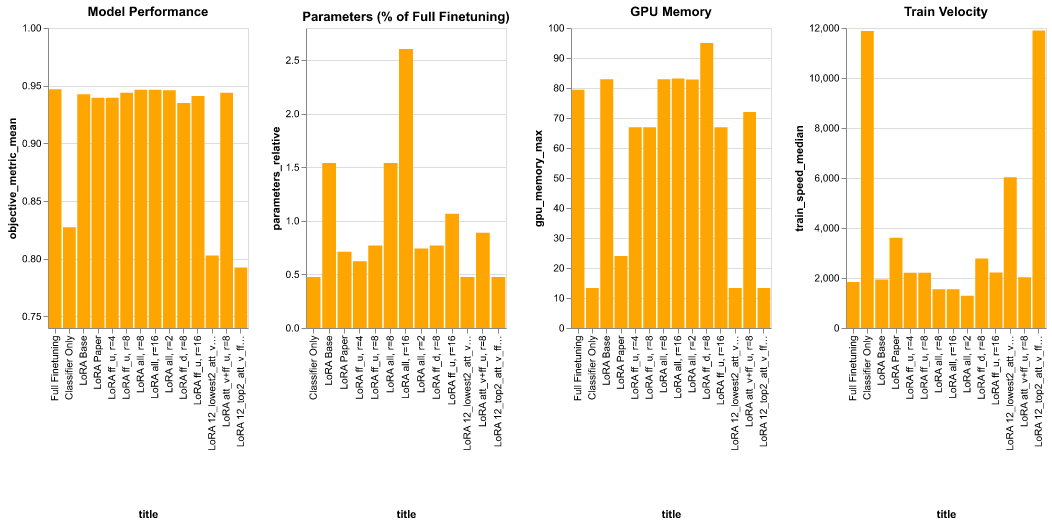

In [6]:
graph_results()

## Not considered

Given all the combinations possible there are many angles we could have pursuit, but limited ourselves to a smaller scope to keep things manageable and understandable. Amongst the angles not evaluated one stands out worth considering in the future: **Per-Adapter-R**. 

We see that on one hand the position-wise feed forward linear modules (`ff_up`, `ff_down` above) have more capacity than the linear modules used in attention. Assuming that they have been sized properly during pre-training, their larger capacity could also mean for fine-tuning that they can carry more information. It could be sensible then to use a higher rank than for the attention linear modules. On the other hand it could be that the specific finetuning task at hand is different enough from pre-training, that the original sizing is not appropriate and, here again, you can pick a specific r for specific modules, say the query linear modules that are close to the task head.
